# Empirical Risk Minimization (ERM) Decision Boundaries

Quick demo of how to draw decision boundaries for ERM with two classes, $C=2$.

Imports for this notebook:

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal # MVN not univariate

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

Consider $N = 1000$ random iid (independent and identically distributed) 2-dimensional samples drawn from two Gaussian PDFs $\mathcal{N}(\boldsymbol{\mu}_i,\boldsymbol{\Sigma}_i)$ with 

\begin{equation*}
    \boldsymbol{\mu}_0=\begin{bmatrix} -4\\0 \end{bmatrix} ~~~
    \boldsymbol{\Sigma}_0=\frac{1}{13}\begin{bmatrix}95 & -2 \\-2 & 3 \end{bmatrix}, ~~~
    \boldsymbol{\mu}_1=\begin{bmatrix} 4\\0 \end{bmatrix} ~~~
    \boldsymbol{\Sigma}_1=\frac{1}{3}\begin{bmatrix}5 & 1 \\1 & 4 \end{bmatrix}. ~~~
\end{equation*}

Also assume class priors $p(L=0)=0.6$ and $p(L=1)=0.4$.

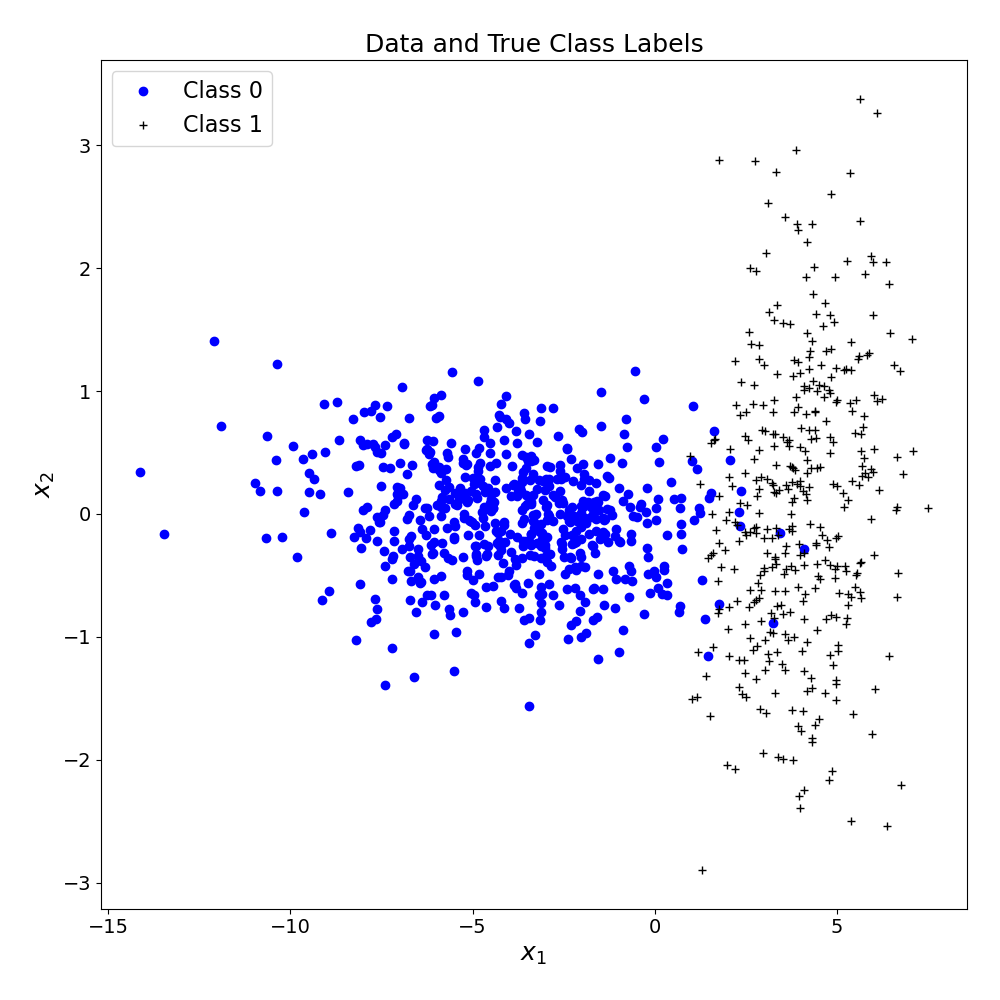

In [2]:
# Number of samples to draw from each distribution
N = 1000

mu = np.array([[-4, 0],
               [4, 0]])  # Gaussian distributions means
Sigma = np.array([[[95, -2],
                   [-2, 3]],
                  [[5, 1],
                   [1, 4]]])  # Gaussian distributions covariance matrices
Sigma = np.array((Sigma[0]/13, Sigma[1]/3))

# Determine dimensionality from PDF parameters
n = mu.shape[1]

# Class priors
priors = np.array([0.6, 0.4])  
C = len(priors)

# Decide randomly which samples will come from each component
labels = np.random.rand(N) >= priors[0]
L = np.array(range(C))
Nl = np.array([sum(labels == i) for i in L])

# Draw samples from each class PDF
X = np.zeros((N, n))
X[labels == 0, :] =  multivariate_normal.rvs(mu[0], Sigma[0], Nl[0])
X[labels == 1, :] =  multivariate_normal.rvs(mu[1], Sigma[1], Nl[1])


# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
plt.plot(X[labels==0, 0], X[labels==0, 1], 'bo', label="Class 0")
plt.plot(X[labels==1, 0], X[labels==1, 1], 'k+', label="Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Class Labels")
plt.tight_layout()
plt.show()

To implement our ERM classifier for this problem, we will assume the <b>0-1 loss</b> setting, such that ERM reduces down to maximum a posteriori (<b>MAP</b>). For a $C=2$ binary classification problem, the conditional risk scores of deciding class 0 or 1 given data $\mathbf{x}$ are:

$$R(D = 0 \, | \, \mathbf{x}) = \lambda_{00} p(L = 0 \, | \, \mathbf{x}) + \lambda_{01} p(L = 1 \, | \, \mathbf{x}),$$
$$R(D = 1 \, | \, \mathbf{x}) = \lambda_{10} p(L = 0 \, | \, \mathbf{x}) + \lambda_{11} p(L = 1 \, | \, \mathbf{x}).$$

With $\lambda_{ij}$ as the loss associated with deciding class label $i$ given $\mathbf{x}$ <i>actually</i> comes from class label $j$, and $p(L = j \, | \, \mathbf{x})$ is the true class posterior probability. As per the objective of ERM, we decide $D = 0$ if $R(D = 0 \, | \, \mathbf{x}) < R(D = 1 \, | \, \mathbf{x})$, and vice versa for deciding $D = 1$. Therefore, after using Bayes rule to determine the true class posteriors from their likelihood $p(\mathbf{x};\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)$ and prior $p(L = j)$ probabilities, the ERM decision rule for the $C=2$ case can now be expressed as a <b>likelihood-ratio test</b>:

\begin{equation*}
\frac{p(\mathbf{x};\boldsymbol{\mu}_1,\boldsymbol{\Sigma}_1)}{p(\mathbf{x};\boldsymbol{\mu}_0,\boldsymbol{\Sigma}_0)} \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \frac{(\lambda_{10} - \lambda_{00})}{(\lambda_{01} - \lambda_{11})} \frac{p(L=0)}{p(L=1)}.
\end{equation*}

However evaluating these loss $\lambda_{ij}$ entries is unnecessary as we are assuming 0-1 loss, where zero loss is assigned to correct classifications and unit loss for all misclassified results (see the [other ERM notebook](erm_gmm.ipynb#ERM-Classification-using-True-Knowledge-of-PDF) for further information).

<b>Task:</b> Using this MAP classifier, plot a visualization of the data as a 2-dimensional scatter plot, with true labels and decision labels indicated using two separate visulization cues, such as marker shape and marker color. Also comment on probability of error.

Smallest Pr(error) for ERM = 0.018


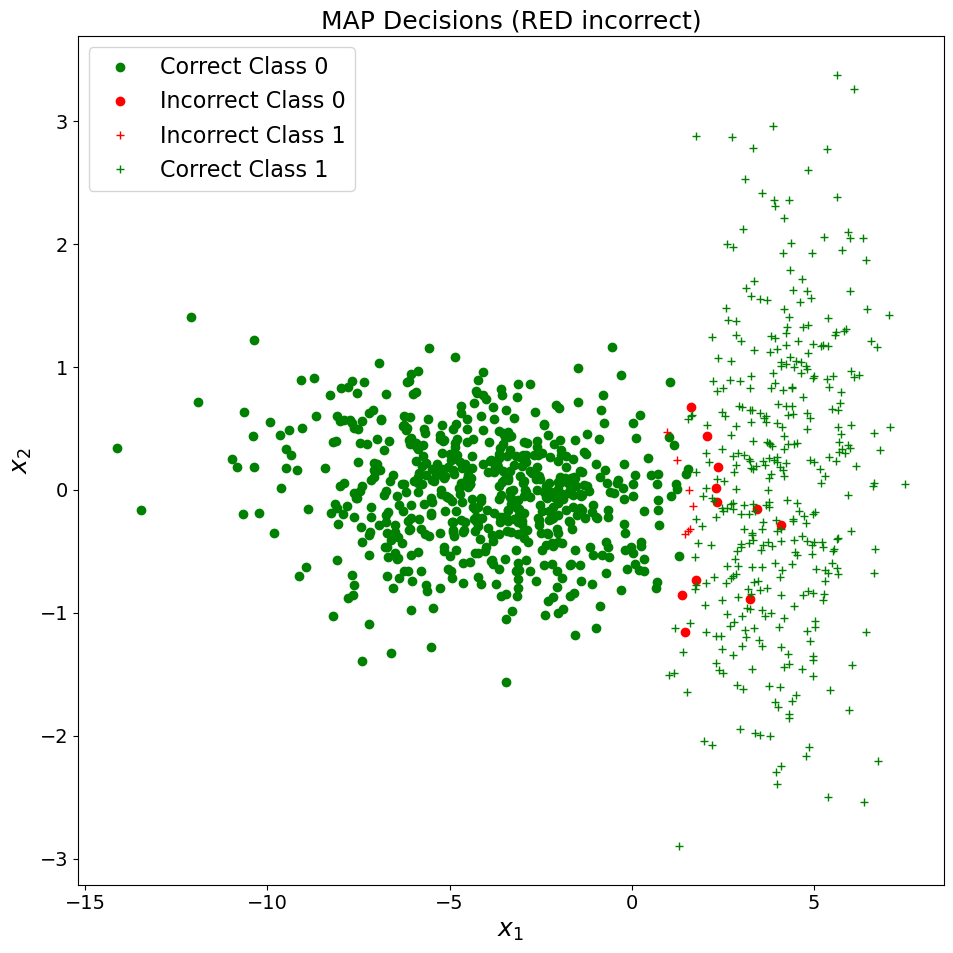

In [3]:
# Expected Risk Minimization Classifier (using true model parameters)
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[i], Sigma[i]) for i in L])
# Discriminant score is LHS of likelihood-ratio test (LRT) 
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Gamma threshold for MAP decision rule (same gamma on priors only; 0-1 loss simplification)
gamma_map = priors[0] / priors[1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_map = np.argwhere((decisions_map==0) & (labels==0))
p_00_map = len(ind_00_map) / Nl[0]
# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / Nl[0]
# False Negative Probability
ind_01_map = np.argwhere((decisions_map==0) & (labels==1))
p_01_map = len(ind_01_map) / Nl[1]
# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / Nl[1]

# Probability of error for MAP classifier, empirically estimated
prob_error_erm = np.array((p_10_map, p_01_map)).dot(Nl.T / N)
print("Smallest Pr(error) for ERM = {}".format(prob_error_erm))

# Display MAP decisions
plt.ioff() # These are Jupyter only lines to avoid showing the figure when I don't want
fig_disc_grid, ax_disc = plt.subplots(figsize=(10, 10));
plt.ion() # Re-activate "interactive" mode

# class 0 circle, class 1 +, correct green, incorrect red
ax_disc.plot(X[ind_00_map, 0], X[ind_00_map, 1], 'og', label="Correct Class 0");
ax_disc.plot(X[ind_10_map, 0], X[ind_10_map, 1], 'or', label="Incorrect Class 0");
ax_disc.plot(X[ind_01_map, 0], X[ind_01_map, 1], '+r', label="Incorrect Class 1");
ax_disc.plot(X[ind_11_map, 0], X[ind_11_map, 1], '+g', label="Correct Class 1");

ax_disc.legend();
ax_disc.set_xlabel(r"$x_1$");
ax_disc.set_ylabel(r"$x_2$");
ax_disc.set_title("MAP Decisions (RED incorrect)");
fig_disc_grid.tight_layout();

display(fig_disc_grid) # Display as .png

fig_disc_grid;

## Plotting Decision Boundaries

The <b>decision boundaries</b> for our MAP classifier is when there is no clear decision between class 0 and 1, i.e., when the LHS and RHS of the following likelihood-ratio test are equal:

\begin{equation*}
\ln p(\mathbf{x};\boldsymbol{\mu}_1,\boldsymbol{\Sigma}_1) - \ln p(\mathbf{x};\boldsymbol{\mu}_0,\boldsymbol{\Sigma}_0) \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \ln \gamma,
\end{equation*}

where $\gamma$ is the ratio of priors $\frac{p(L=0)}{p(L=1)}$ and note that we have taken the $\log$ of each side.

Or alternatively we can rearrange as:

\begin{equation*}
\ln p(\mathbf{x};\boldsymbol{\mu}_1,\boldsymbol{\Sigma}_1) - \ln p(\mathbf{x};\boldsymbol{\mu}_0,\boldsymbol{\Sigma}_0) - \ln \gamma = 0.
\end{equation*}

Now let us plot the ERM decision boundaries for our dataset distribution by generating a grid of class-conditional likelihood probabilities across the input sample space, and drawing contours based on the evaluated discriminant scores:

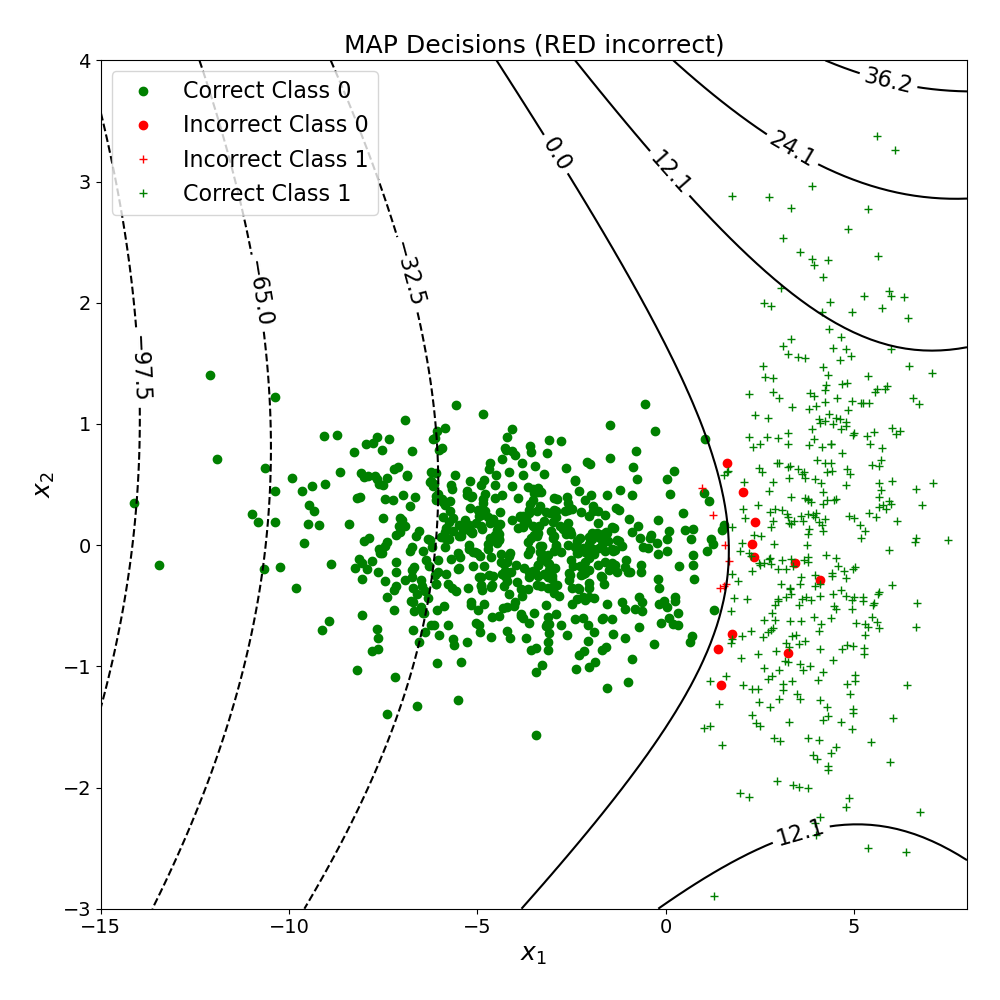

In [4]:
# Note that I am creating a 100x100 rectangular grid
horizontal_grid = np.linspace(np.floor(np.min(X[:,0])), np.ceil(np.max(X[:,0])), 100)
vertical_grid = np.linspace(np.floor(np.min(X[:,1])), np.ceil(np.max(X[:,1])), 100)

# Generate a grid of scores that spans the full range of data 
[h, v] = np.meshgrid(horizontal_grid, vertical_grid)
# Flattening to feed vectorized matrix in PDF evaluation
gridxy = np.array([h.reshape(-1), v.reshape(-1)])
# Class-conditional likelihoods per grid coordinate, shaped [C, 100*100], which is [2, 10000] in this example
likelihood_grid_vals = np.array([multivariate_normal.pdf(gridxy.T, mu[i], Sigma[i]) for i in L])

# Where a score of 0 indicates decision boundary level
discriminant_score_grid_vals = np.log(likelihood_grid_vals[1]) - np.log(likelihood_grid_vals[0]) - np.log(gamma_map)

# Contour plot of decision boundaries
discriminant_score_grid_vals = np.array(discriminant_score_grid_vals).reshape(100, 100)
# The next four lines just determine how I'll draw contour lines at 9 discriminant score grid value (DSGV) levels:
# .9 * min_DSGV, .6 * min_DSGV, .3 * min_DSGV, 0, .3 * max_DSGV, .6 * max_DSGV, .9 * max_DSGV
equal_levels = np.array((0.3, 0.6, 0.9))
min_DSGV = np.min(discriminant_score_grid_vals) * equal_levels[::-1] # Reversing the levels list [.9, .6, .3]
max_DSGV = np.max(discriminant_score_grid_vals) * equal_levels
contour_levels = min_DSGV.tolist() + [0] + max_DSGV.tolist()
# Plot contours
cs = ax_disc.contour(horizontal_grid, vertical_grid, discriminant_score_grid_vals, contour_levels, colors='k')
ax_disc.clabel(cs, fontsize=16, inline=1)

plt.show()
fig_disc_grid;